In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.pipeline import Pipeline

In [18]:
filename = "Real estate.csv"

spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(filename, header=True, inferSchema=True, sep=',')
df.show()

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|
|  2|           2012.917|        19.5|                              306.5947|                              9|   24.98034|   121.53951|                      42.2|
|  3|           2013.583|        13.3|                              561.9845|                              5|   24.98746|   121.54391|                      47.3|
|  4|             2013.5|   

In [19]:
df.count()

414

# Exploratory Data Analysis (EDA)

In [20]:
df.printSchema()

root
 |-- No: integer (nullable = true)
 |-- X1 transaction date: double (nullable = true)
 |-- X2 house age: double (nullable = true)
 |-- X3 distance to the nearest MRT station: double (nullable = true)
 |-- X4 number of convenience stores: integer (nullable = true)
 |-- X5 latitude: double (nullable = true)
 |-- X6 longitude: double (nullable = true)
 |-- Y house price of unit area: double (nullable = true)



In [21]:
df.dtypes

[('No', 'int'),
 ('X1 transaction date', 'double'),
 ('X2 house age', 'double'),
 ('X3 distance to the nearest MRT station', 'double'),
 ('X4 number of convenience stores', 'int'),
 ('X5 latitude', 'double'),
 ('X6 longitude', 'double'),
 ('Y house price of unit area', 'double')]

In [22]:
#missing values check
from pyspark.sql.functions import count, when, isnan, col

# miss_percentage is set to 80% as discussed in the book
def missing_calculation(df, miss_percentage=0.80):
    
    #checks for both NaN and null values
    missing = df.select(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
    length_df = df.count()
    ## convert to pandas for efficient calculations
    final_missing_df = missing.toPandas().transpose()
    final_missing_df.reset_index(inplace=True) 
    final_missing_df.rename(columns={0:'missing_count'}, inplace=True) 
    final_missing_df['missing_percentage'] = final_missing_df['missing_count']/length_df
    
    #select variables with cardinality of 1
    vars_selected = final_missing_df['index'][final_missing_df['missing_percentage'] >= miss_percentage] 
    
    return final_missing_df, vars_selected

In [23]:
missing_df, missing_vars_selected = missing_calculation(df)

In [24]:
missing_df

,index,missing_count,missing_percentage
0,No,0,0.0
1,X1 transaction date,0,0.0
2,X2 house age,0,0.0
3,X3 distance to the nearest MRT station,0,0.0
4,X4 number of convenience stores,0,0.0
5,X5 latitude,0,0.0
6,X6 longitude,0,0.0
7,Y house price of unit area,0,0.0


In [25]:
missing_vars_selected

Series([], Name: index, dtype: object)

In [26]:
# Count the number of duplicates in the DataFrame
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


**Pairplot visualization to show correlations among numerical variables**

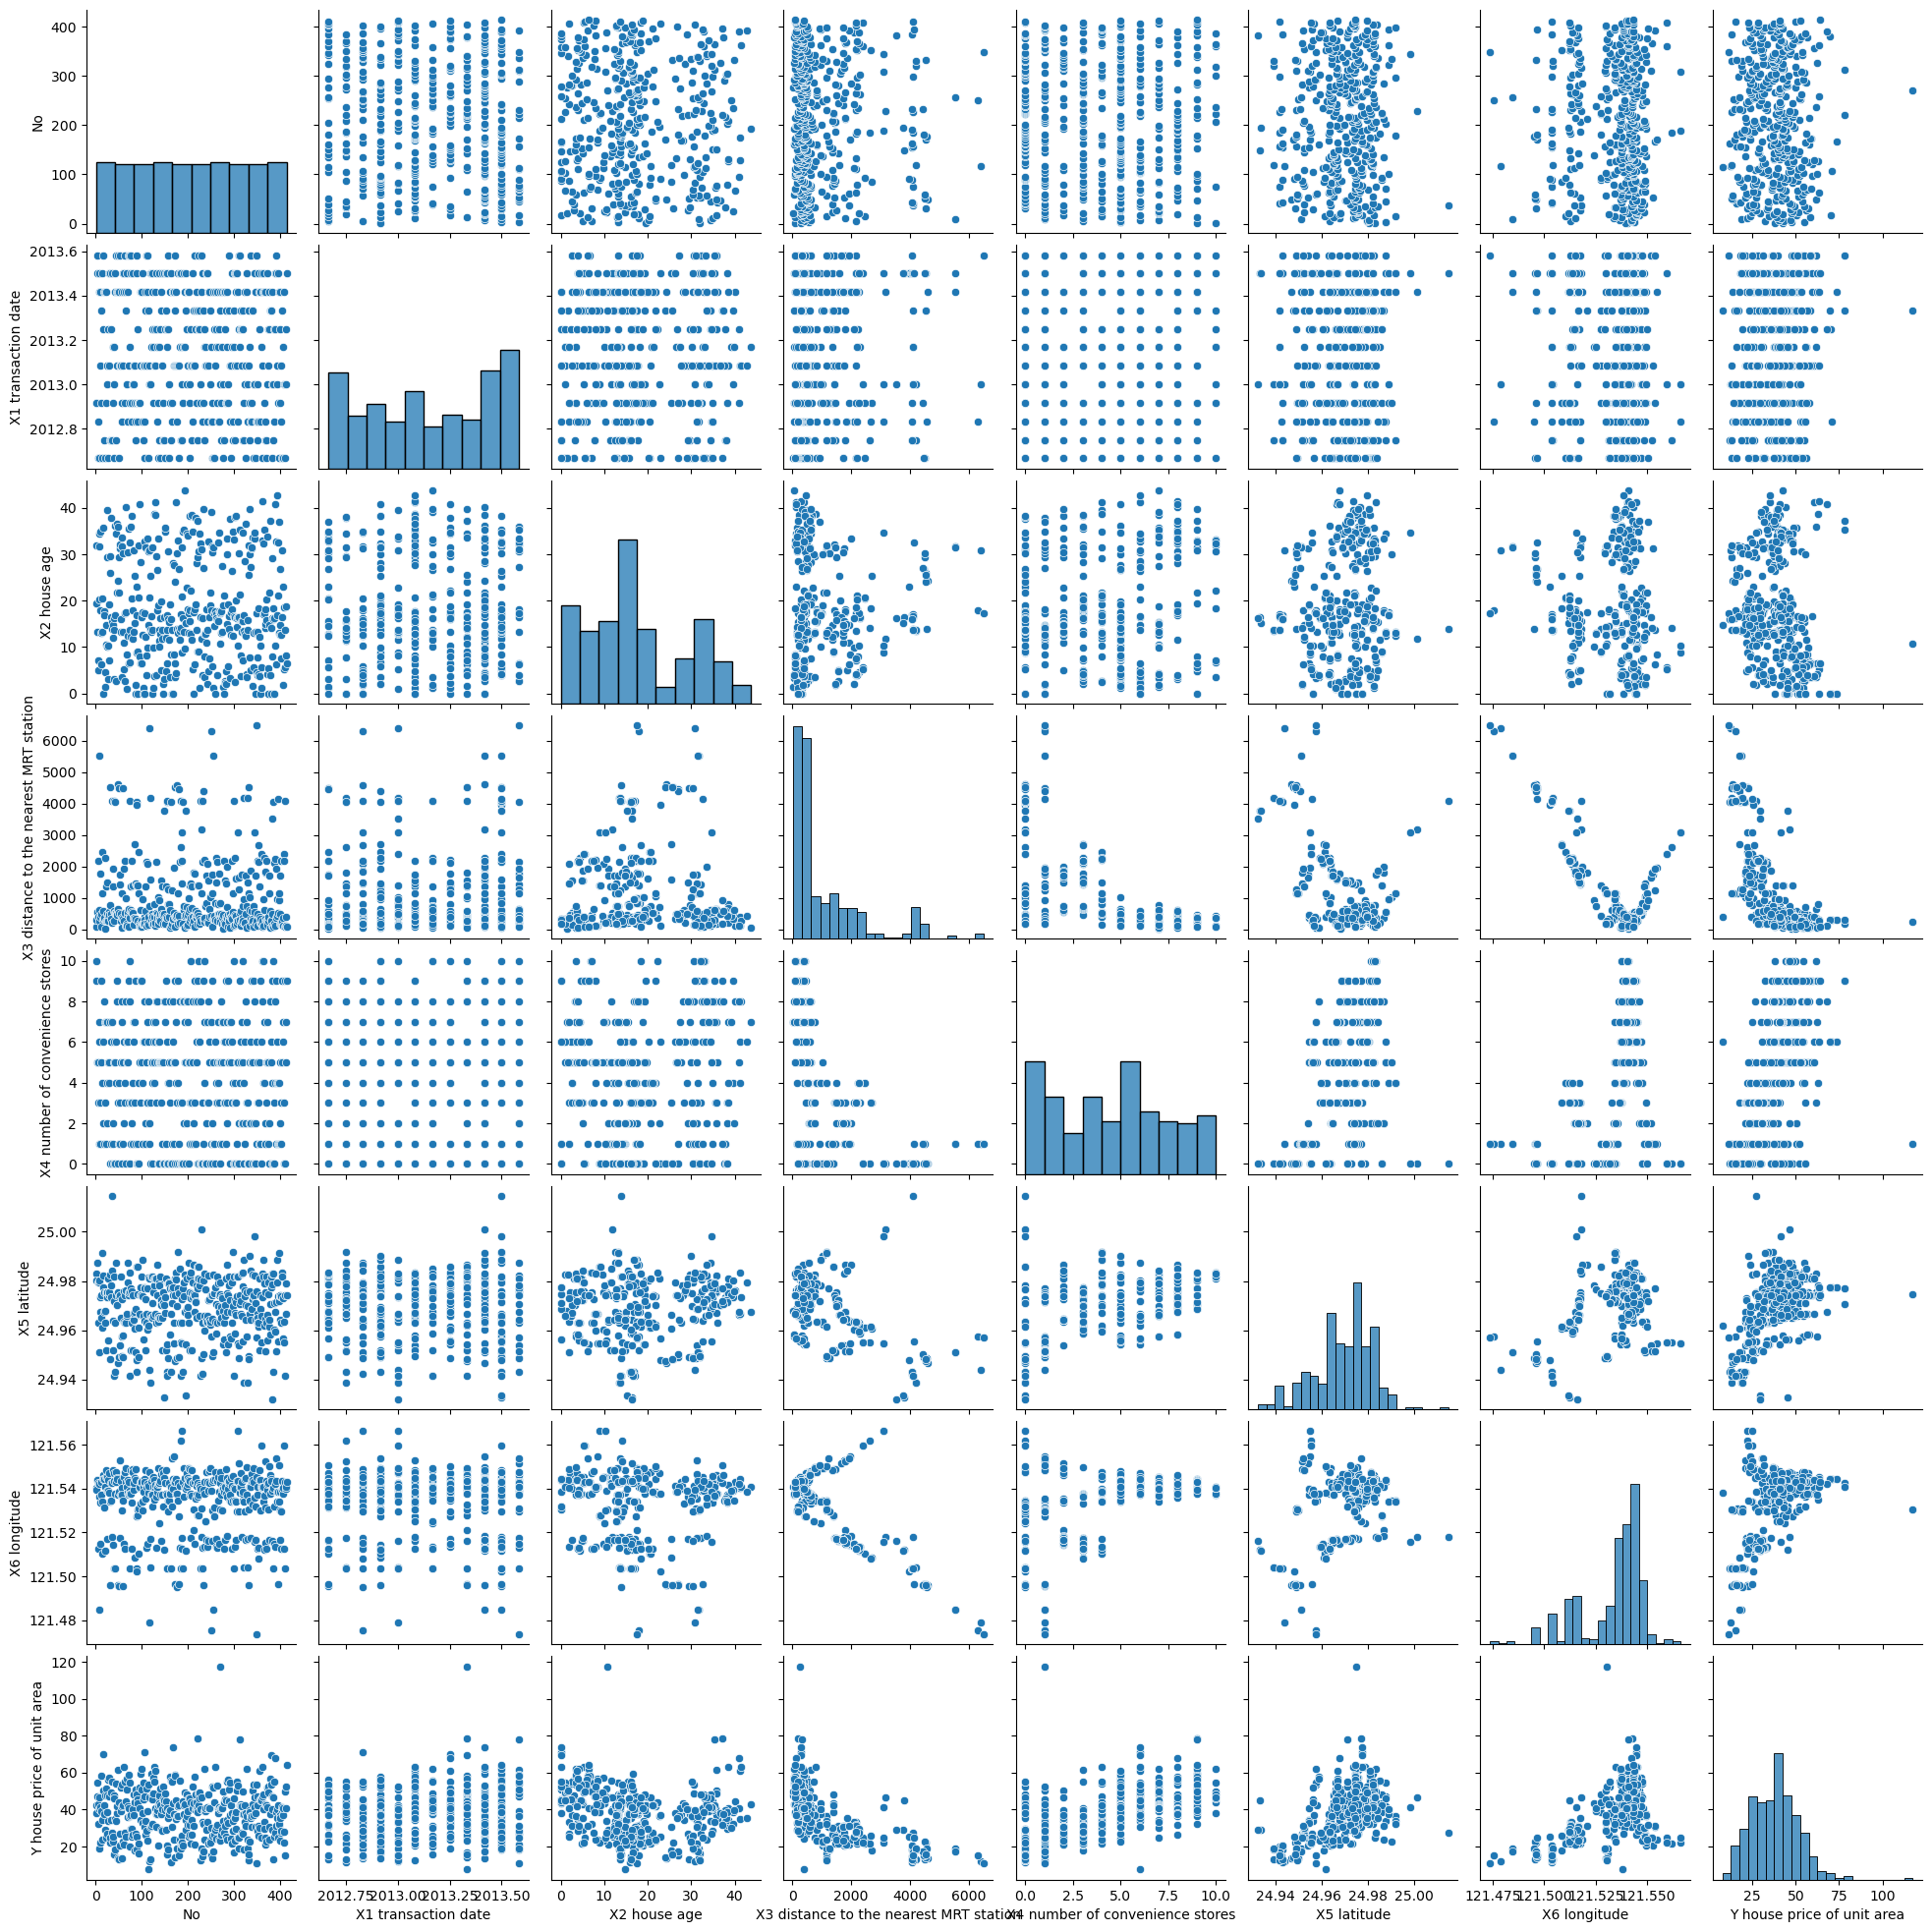

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Convert PySpark DataFrame to Pandas DataFrame for visualization
pandas_df = df.toPandas()

# Plot pairwise relationships using Seaborn (Pandas DataFrame)
sns.pairplot(pandas_df)
plt.show()

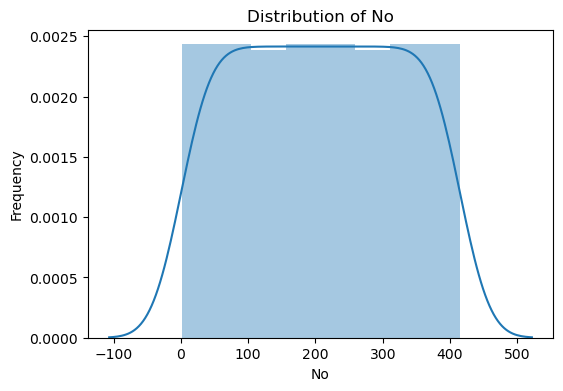

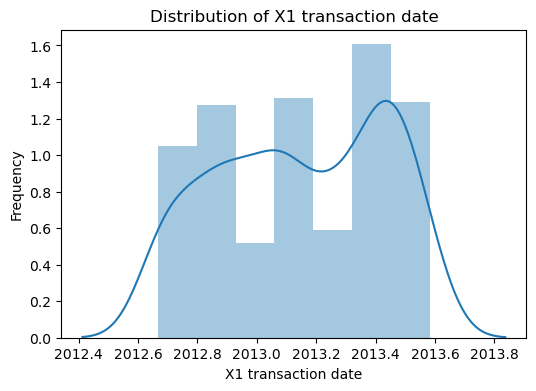

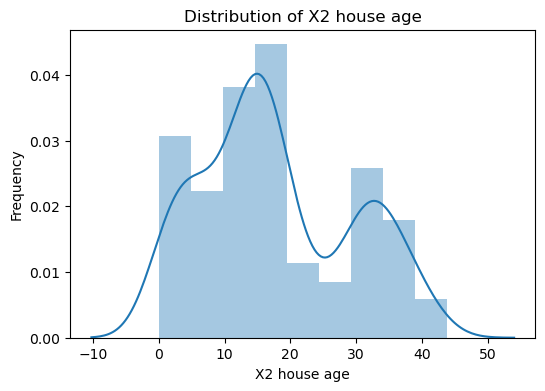

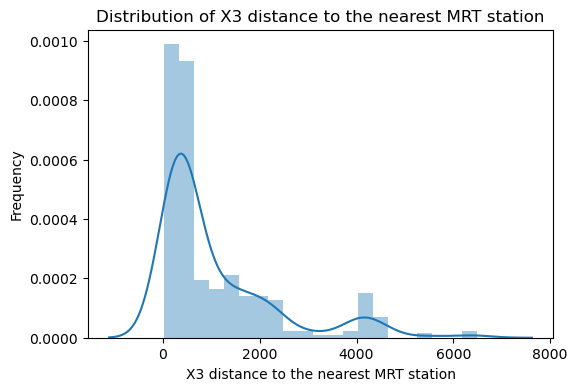

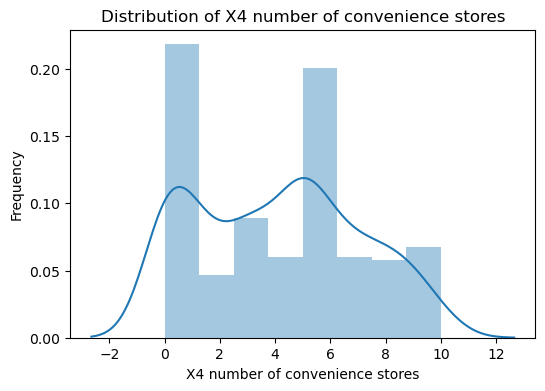

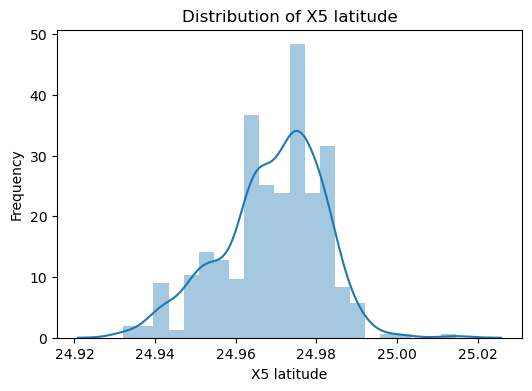

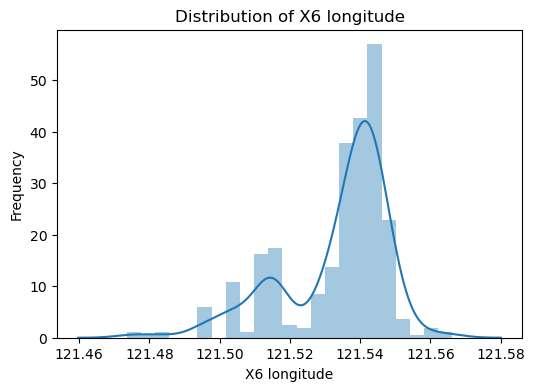

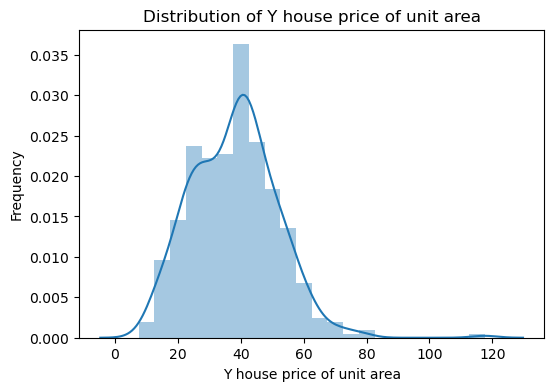

In [30]:
#Distribution of each variable
import warnings
warnings.filterwarnings("ignore")
# Convert PySpark DataFrame to Pandas DataFrame for visualization
pandas_df = df.toPandas()

# Plot distributions for each column
for col in pandas_df.columns:
    plt.figure(figsize=(6, 4))
    sns.distplot(pandas_df[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

**Determining association between individual and target variables**

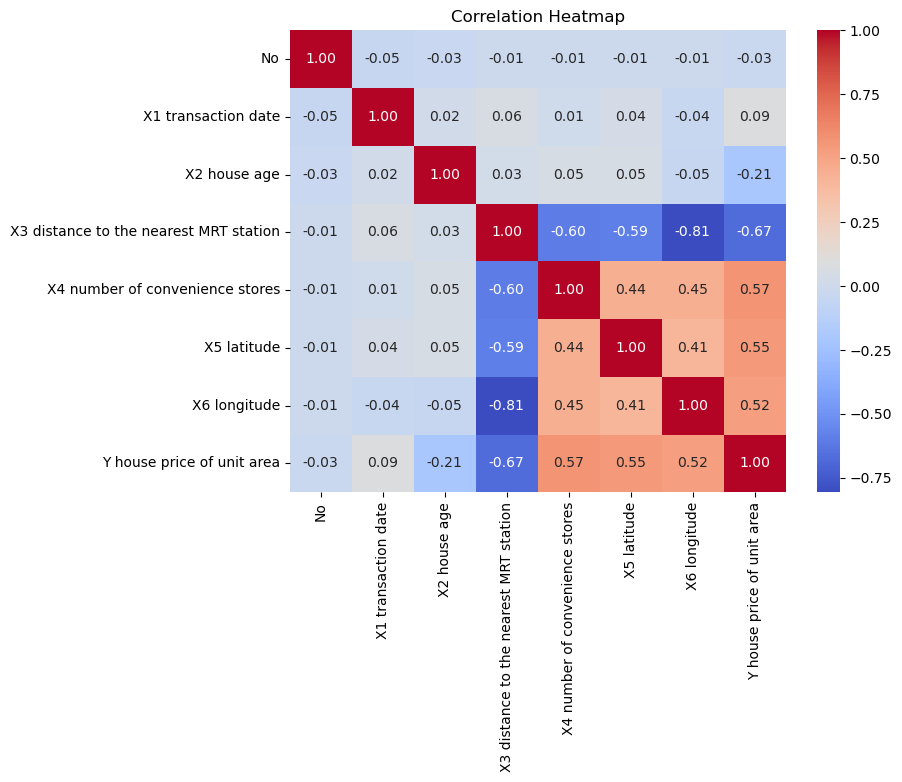

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

df_updated = df.toPandas()

# Calculate correlation matrix
correlation_matrix = df_updated.corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Purpose of Heatmap Visualization : illustrate linear correlations between variables 

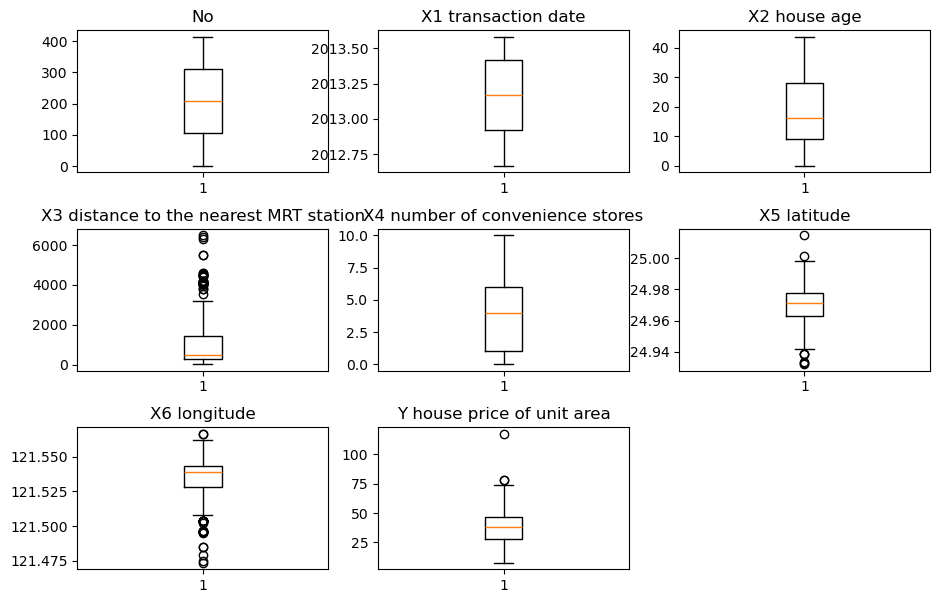

In [39]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(11, 7))
plt.subplots_adjust(hspace=0.4)

# Check the number of columns in df_updated
num_columns = df_updated.shape[1]

column_count = 0

for i in range(3):
    for y in range(3):
        if column_count < num_columns:
            ax[i, y].boxplot(df_updated.iloc[:, column_count])
            ax[i, y].set_title(df_updated.columns[column_count])
            column_count += 1
        else:
            # If there are fewer than 9 columns, fill the remaining subplots with blank plots
            ax[i, y].axis('off')

Purpose of Boxplot : Show the relationship between variables

In [40]:
import numpy as np

In [41]:
train, test = df.randomSplit([0.7, 0.3], seed=12345)

In [42]:
#Assembler

target_variable_name = "csMPa"

#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    stages = [assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features']
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)

    return df

In [44]:
#exclude target variable and select all other feature vectors
features_list = df.columns
#features_list = char_vars #this option is used only for ChiSqselector
features_list.remove('Y house price of unit area')

In [45]:
features_list

['No',
 'X1 transaction date',
 'X2 house age',
 'X3 distance to the nearest MRT station',
 'X4 number of convenience stores',
 'X5 latitude',
 'X6 longitude']

In [47]:
# apply the function on our dataframe
assembled_df = assemble_vectors(train, features_list, 'Y house price of unit area')

In [48]:
assembled_df.show()

+--------------------------+--------------------+
|Y house price of unit area|            features|
+--------------------------+--------------------+
|                      37.9|[1.0,2012.917,32....|
|                      42.2|[2.0,2012.917,19....|
|                      47.3|[3.0,2013.583,13....|
|                      54.8|[4.0,2013.5,13.3,...|
|                      43.1|[5.0,2012.833,5.0...|
|                      32.1|[6.0,2012.667,7.1...|
|                      46.7|[8.0,2013.417,20....|
|                      18.8|[9.0,2013.5,31.7,...|
|                      22.1|[10.0,2013.417,17...|
|                      41.4|[11.0,2013.083,34...|
|                      58.1|[12.0,2013.333,6....|
|                      39.3|[13.0,2012.917,13...|
|                      34.3|[15.0,2013.5,13.2...|
|                      50.5|[16.0,2013.583,35...|
|                      70.1|[17.0,2013.25,0.0...|
|                      42.3|[19.0,2013.417,16...|
|                      47.7|[20.0,2012.667,1....|


# Modelling

### Linear Regression

In [50]:
reg = LinearRegression(featuresCol='features', labelCol='Y house price of unit area')
reg_model = reg.fit(assembled_df) # fit model

In [51]:
import pandas as pd
for k, v in assembled_df.schema["features"].metadata["ml_attr"]["attrs"].items():
    features_df = pd.DataFrame(v)

features_df['coefficients'] = reg_model.coefficients

features_df

,idx,name,coefficients
0,0,No,-0.004111
1,1,X1 transaction date,3.761689
2,2,X2 house age,-0.311604
3,3,X3 distance to the nearest MRT station,-0.004808
4,4,X4 number of convenience stores,1.058447
5,5,X5 latitude,193.794506
6,6,X6 longitude,-20.085897


In [52]:
#prediction result
pred_result = reg_model.transform(assembled_df)

pred_result.show()

+--------------------------+--------------------+------------------+
|Y house price of unit area|            features|        prediction|
+--------------------------+--------------------+------------------+
|                      37.9|[1.0,2012.917,32....| 47.06366069512842|
|                      42.2|[2.0,2012.917,19....|  48.3332130133349|
|                      47.3|[3.0,2013.583,13....|  48.5960939665074|
|                      54.8|[4.0,2013.5,13.3,...| 48.27976233206937|
|                      43.1|[5.0,2012.833,5.0...| 47.63860095315613|
|                      32.1|[6.0,2012.667,7.1...| 33.09730578185372|
|                      46.7|[8.0,2013.417,20....| 46.81594224552282|
|                      18.8|[9.0,2013.5,31.7,...| 8.608765383130958|
|                      22.1|[10.0,2013.417,17...|35.199742499409695|
|                      41.4|[11.0,2013.083,34...| 34.00018208022084|
|                      58.1|[12.0,2013.333,6....| 53.77249959907385|
|                      39.3|[13.0,

In [53]:
#Evaluation
reg_summary = reg_model.summary

print('Mean Squared error= ', reg_summary.meanSquaredError)
print('Root mean squared error= ', reg_summary.rootMeanSquaredError)
print('Mean Absolute error= ', reg_summary.meanAbsoluteError)
print('Explained Variance= ', reg_summary.explainedVariance)
print('R squared= ', reg_summary.r2)

Mean Squared error=  74.60571941123163
Root mean squared error=  8.637460240790208
Mean Absolute error=  5.913618371383897
Explained Variance=  111.98269657538845
R squared=  0.6001588896529844


### Random Forest Regressor

In [54]:
rf = RandomForestRegressor(featuresCol="features", labelCol="Y house price of unit area")
rf_model = rf.fit(assembled_df)
# print(reg_model.featureImportances)
# print(reg_model.toDebugString)

In [55]:
#Evaluation
# Make predictions on the test set
predictions = rf_model.transform(assembled_df)

# Selecting the evaluator and computing RMSE
evaluator = RegressionEvaluator(labelCol="Y house price of unit area", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
evaluator = RegressionEvaluator(labelCol='Y house price of unit area', predictionCol='prediction', metricName='mse')
mse = evaluator.evaluate(predictions)
evaluator = RegressionEvaluator(labelCol='Y house price of unit area', predictionCol='prediction', metricName='mae')
mae = evaluator.evaluate(predictions)
evaluator = RegressionEvaluator(labelCol='Y house price of unit area', predictionCol='prediction', metricName='var')
var = evaluator.evaluate(predictions)
evaluator = RegressionEvaluator(labelCol='Y house price of unit area', predictionCol='prediction', metricName='r2')
r2 = evaluator.evaluate(predictions)



print("Root Mean Squared Error (RMSE) on test data: {:.4f}".format(rmse))
print("Mean Squared Error (MSE) on test data: {:.4f}".format(mse))
print("Mean Absollute Error (MAE) on test data: {:.4f}".format(mae))
print("var on test data: {:.4f}".format(var))
print("R-2 on test data: {:.4f}".format(r2))


Root Mean Squared Error (RMSE) on test data: 5.2565
Mean Squared Error (MSE) on test data: 27.6305
Mean Absollute Error (MAE) on test data: 3.6507
var on test data: 130.7267
R-2 on test data: 0.8519


# Summary

**Linear Regression**

The Linear Regression model has a lower R² score (0.6002), explaining only 60% of the data variance, with higher error rates. This indicates less accuracy and predictive ability compared to the Random Forest model.

**Random Forest Regressor**

With a higher R² score (0.8519), the Random Forest model explains about 85% of the variance in the dataset, showing high predictive power. It also achieves significantly lower error rates (MSE, RMSE, and MAE) compared to Linear Regression, indicating better accuracy.

**Conclution**

The Random Forest Regressor is the best-performing model for this dataset, providing more accurate predictions and a stronger explanation of variance.